<a href="https://colab.research.google.com/github/liu-bioinfo-lab/general_AI_model/blob/main/runbook_obtaining_representations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please open Google Colab notebook under TPU/GPU setting : **Runtime -> Change runtime type**

In [1]:
!git clone https://github.com/liu-bioinfo-lab/general_AI_model.git
%cd general_AI_model

fatal: destination path 'general_AI_model' already exists and is not an empty directory.
/nfs/turbo/umms-drjieliu/usr/xinyubao/clipEPCOT/general_AI_model/general_AI_model


In [2]:
import os
import gdown
from src.model import build_model
import argparse
import torch
try:
  import torch_xla
  import torch_xla.core.xla_model as xm
  import torch_xla.distributed.xla_multiprocessing as xmp
except Exception as e:
  print(f" Error: {e}")
!pip install kipoiseq==0.5.2 --quiet > /dev/null
import kipoiseq
from kipoiseq import Interval
import pyfaidx
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from src.tutorial_utils import FastaStringExtractor, prepare_input, extract_outputs, get_args

 Error: No module named 'torch_xla'


**Download Model**

In [3]:
os.makedirs('models', exist_ok=True)
model_path = 'models/ckpt.pt'
gdown.download('https://drive.google.com/uc?id=1aTpGvAUkvaxsDP_isA2n2Udbfqa9walW', model_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1aTpGvAUkvaxsDP_isA2n2Udbfqa9walW
From (redirected): https://drive.google.com/uc?id=1aTpGvAUkvaxsDP_isA2n2Udbfqa9walW&confirm=t&uuid=e6ec90bb-8a58-44af-b5fe-372ee3906a80
To: /nfs/turbo/umms-drjieliu/usr/xinyubao/clipEPCOT/general_AI_model/general_AI_model/models/ckpt.pt
100%|██████████| 468M/468M [00:51<00:00, 9.07MB/s] 


'models/ckpt.pt'

In [4]:

### The following codes are copied from https://github.com/deepmind/deepmind-research/blob/master/enformer/enformer-usage.ipynb
fasta_file = 'data/genome.fa'
!mkdir -p data
!wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > {fasta_file}
pyfaidx.Faidx(fasta_file)
!ls data

fasta_extractor = FastaStringExtractor(fasta_file)

--2025-10-02 10:35:09--  http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
Resolving proxy1.arc-ts.umich.edu (proxy1.arc-ts.umich.edu)... 141.211.192.53
Connecting to proxy1.arc-ts.umich.edu (proxy1.arc-ts.umich.edu)|141.211.192.53|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 983659424 (938M) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>] 938.09M  18.8MB/s    in 47s     

2025-10-02 10:35:56 (20.1 MB/s) - written to stdout [983659424/983659424]

accession_number.xlsx  epi_list		  genome.fa.fai		  README.md
black_list.bed	       extra_tf_list.txt  hic_process.py
data_read.py	       genome.fa	  input_region_600kb.bed


In [5]:
# Download a downsampled GM12878 ATAC-seq for example
os.makedirs('tmp_save', exist_ok=True)
atac_path = 'tmp_save/GM12878_ATAC.pickle'
gdown.download('https://drive.google.com/uc?id=1ua-fQHYjPH658oEKEpIaDBHNFbzsO1m0', atac_path, quiet=False)
with open(atac_path, 'rb') as f:
    atac_data = pickle.load(f)

Downloading...
From (original): https://drive.google.com/uc?id=1ua-fQHYjPH658oEKEpIaDBHNFbzsO1m0
From (redirected): https://drive.google.com/uc?id=1ua-fQHYjPH658oEKEpIaDBHNFbzsO1m0&confirm=t&uuid=ed6564e4-492a-437e-8d0a-55ecf55d9764
To: /nfs/turbo/umms-drjieliu/usr/xinyubao/clipEPCOT/general_AI_model/general_AI_model/tmp_save/GM12878_ATAC.pickle
100%|██████████| 192M/192M [00:19<00:00, 9.83MB/s] 
/tmp/ipykernel_2896164/3254570976.py:6: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  atac_data = pickle.load(f)


### Load model

In [6]:
args = get_args()
try:
    device = xm.xla_device()
    print(f"XLA device detected: {device}")
except Exception as e:
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"No XLA device detected. Error: {e}")

model = build_model(args)
model.load_state_dict(torch.load(model_path, map_location='cpu'),strict=True)
model.eval()
model.to(device)
device

No XLA device detected. Error: name 'xm' is not defined


/tmp/ipykernel_2896164/2176896603.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location='cpu'),strict=True)


device(type='cuda', index=0)

### Run model to get 1D and 2D representations over a 500kb region

In [7]:
# specify a 500kb region

chrom, start, end = ['chr12', 6234512, 6734512]

input_x = prepare_input(
    fasta_extractor,
    chrom, start, end,
    atac_data
).to(device)

outputs = model(input_x,return_rep=True)

rep1d, rep2d = extract_outputs(outputs)

#### embedding size

In [8]:
## representation of each 1kb bin and interactions among 1kb bins in 500kb region
rep1d.shape, rep2d.shape

((500, 960), (500, 500, 96))

### Prediction

In [9]:
modalities=['epi', 'rna', 'bru', 'microc', 'hic','intacthic','rna_strand','external_tf', 'tt', 'groseq', 'grocap', 'proseq','netcage','starr']
_, _, output,external_output = outputs
mix_output=[out.cpu().data.detach().numpy() for out in (output+external_output)]
out_dic=dict(zip(modalities,mix_output))

In [13]:
# the last dimension corresponds to modalities being predicted
for m in modalities:
    print(m,out_dic[m].shape)

epi (1, 500, 247)
rna (1, 500, 3)
bru (1, 500, 3)
microc (1, 500, 500, 2)
hic (1, 100, 100, 3)
intacthic (1, 500, 500, 2)
rna_strand (1, 500, 2)
external_tf (1, 500, 708)
tt (1, 500, 2)
groseq (1, 500, 2)
grocap (1, 500, 4)
proseq (1, 500, 3)
netcage (1, 500, 2)
starr (1, 500, 1)


### Explanation of each modality that can be predicted

* __Epigenomic features (epi).__ The list of epigenomic features can be found in "data/epi_list".

* __RNA-seq (rna).__
  - CAGE-seq
  - Total RNA-seq
  - PolyA+ RNA-seq

* __Bru-seq (bru).__
  - Bru-seq
  - BruUV-seq
  - BruChase-seq

* __Micro-c (microc).__
  - O/E normalized Micro-C
  - KR normalized Micro-C

* __Hi-C (hic).__
  - CTCF ChIA-PET
  - RNApol2 ChIA-PET
  - Hi-C

* __Intact Hi-C (intacthic).__
  - O/E normalized intact Hi-C
  - KR normalized intact Hi-C

* __RNA Strand (rna_strand).__
  - Total RNA-seq (forward)
  - Total RNA-seq (reverse)

* __Additional TFs (external_tf).__ The list of additional TFs can be found on Github in a file named unseen_tf.txt.

* __TT-seq (tt).__
  - TT-seq (forward)
  - TT-seq (reverse)

* __GRO-seq (groseq).__
  - GRO-seq (forward)
  - GRO-seq (reverse)

* __GRO-cap (grocap).__
  - GRO-cap (forward)
  - GRO-cap (reverse)
  - GRO-cap_wTAP (forward)
  - GRO-cap_wTAP(reverse)

* __PRO-seq (proseq).__
  - PRO-seq (forward)
  - PRO-seq (reverse)
  - PRO-cap

* __NET-CAGE (netcage).__
  - NET-CAGE (forward)
  - NET-CAGE (reverse)

* __STARR-seq (starr).__ STARR-seq

### Visualization

#### 2D map

In [30]:
hic=out_dic["hic"] # also for microc, intacthic
hic_map=hic[0,:,:,0]

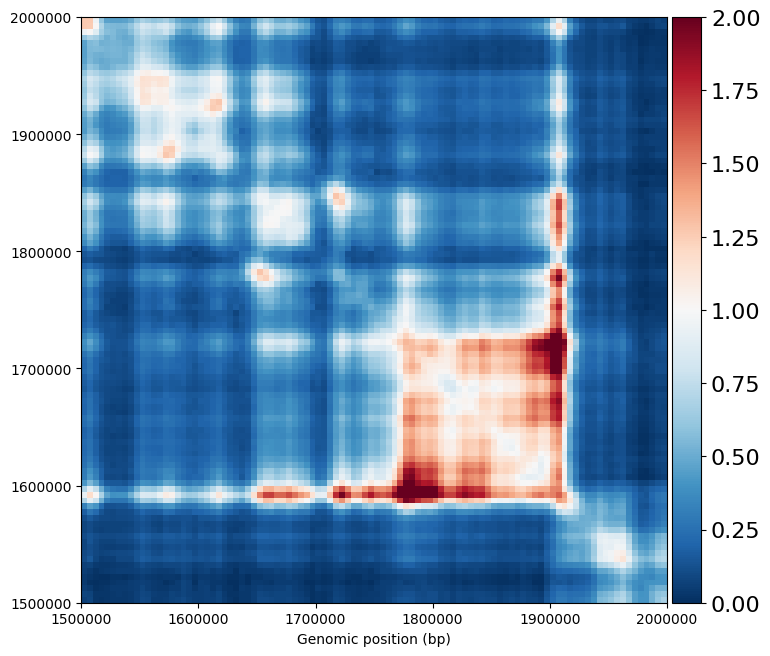

In [61]:
hic_map = np.squeeze(hic_map)
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(hic_map.squeeze(),cmap='RdBu_r',vmin=0,vmax=2,extent=[start, end, start, end],)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.ax.tick_params(labelsize=16)
ax.ticklabel_format(axis='x', style='plain', useOffset=False)
ax.ticklabel_format(axis='y', style='plain', useOffset=False)
ax.set_xlabel("Genomic position (bp)", fontsize=10)
# ax.set_yticks([])
# ax.set_xticks([])
plt.show()

#### 1D sequence

In [18]:
epi_data=out_dic["rna"] # Also for other one dimential sequence
epi_map=epi_data[0,:,2] # You can check the epi list at data/epi_list

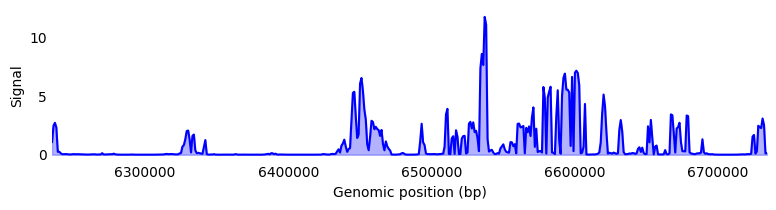

In [19]:
n_bins = epi_map.shape[0]
pixel_width   = (end - start) / n_bins
genomic_coords = start + pixel_width/2 + np.arange(n_bins) * pixel_width
fig, ax = plt.subplots(figsize=(8, 2.2))
sig = np.clip(epi_map, 0, None)
ax.plot(genomic_coords, sig, color='blue', lw=1.5)
ax.fill_between(genomic_coords, 0, sig, alpha=0.3, color='blue')

xlim = (genomic_coords.min(), genomic_coords.max())
ax.set_xlim(xlim)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(axis='both', which='both', length=0)
ax.ticklabel_format(axis='x', style='plain', useOffset=False)
ax.set_xlabel("Genomic position (bp)", fontsize=10)
ax.set_ylabel("Signal", fontsize=10)
plt.tight_layout()

plt.show()


### Examples

In this section we will show examples of every modalities.

#### Epigenomic features

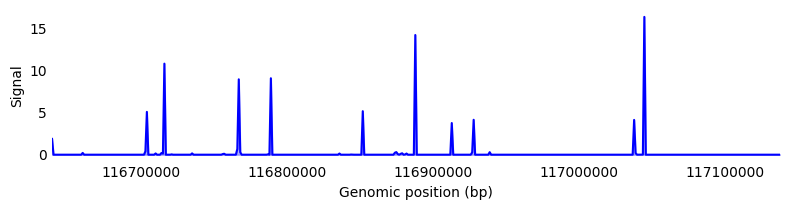

In [7]:
chrom, start, end = ['chr8', 116638207, 117138207] #aroud gene AARD

input_x = prepare_input(
    fasta_extractor,
    chrom, start, end,
    atac_data
).to(device)

_,_,outputs,_ = model(input_x,return_rep=True)

epi_map=outputs[0][0,:,0].cpu().data.detach().numpy() #CTCF
n_bins = epi_map.shape[0]
pixel_width   = (end - start) / n_bins
genomic_coords = start + pixel_width/2 + np.arange(n_bins) * pixel_width
fig, ax = plt.subplots(figsize=(8, 2.2))
sig = np.clip(epi_map, 0, None)
ax.plot(genomic_coords, sig, color='blue', lw=1.5)
ax.fill_between(genomic_coords, 0, sig, alpha=0.3, color='blue')

xlim = (genomic_coords.min(), genomic_coords.max())
ax.set_xlim(xlim)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(axis='both', which='both', length=0)
ax.ticklabel_format(axis='x', style='plain', useOffset=False)
ax.set_xlabel("Genomic position (bp)", fontsize=10)
ax.set_ylabel("Signal", fontsize=10)
plt.tight_layout()

plt.show()

#### RNA

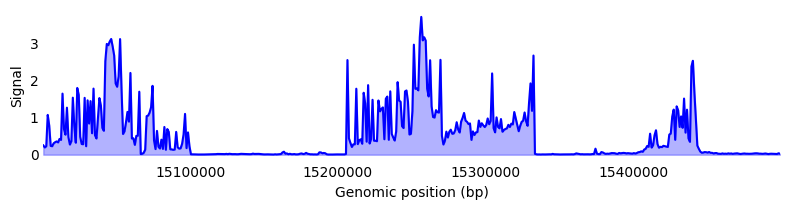

In [ ]:
chrom, start, end = ['chr3', 15000000, 15500000] # around CAPN7

input_x = prepare_input(
    fasta_extractor,
    chrom, start, end,
    atac_data
).to(device)

_,_,outputs,_ = model(input_x,return_rep=True)

epi_map=outputs[1][0,:,1].cpu().data.detach().numpy() #Total RNA
n_bins = epi_map.shape[0]
pixel_width   = (end - start) / n_bins
genomic_coords = start + pixel_width/2 + np.arange(n_bins) * pixel_width
fig, ax = plt.subplots(figsize=(8, 2.2))
sig = np.clip(epi_map, 0, None)
ax.plot(genomic_coords, sig, color='blue', lw=1.5)
ax.fill_between(genomic_coords, 0, sig, alpha=0.3, color='blue')

xlim = (genomic_coords.min(), genomic_coords.max())
ax.set_xlim(xlim)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(axis='both', which='both', length=0)
ax.ticklabel_format(axis='x', style='plain', useOffset=False)
ax.set_xlabel("Genomic position (bp)", fontsize=10)
ax.set_ylabel("Signal", fontsize=10)
plt.tight_layout()

plt.show()

#### Bru-seq

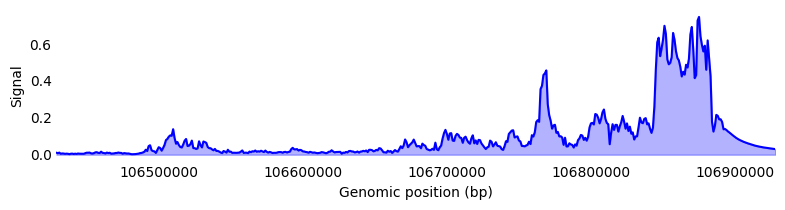

In [17]:
chrom, start, end = ['chr14', 106428615, 106928615] # around IGH

input_x = prepare_input(
    fasta_extractor,
    chrom, start, end,
    atac_data
).to(device)

_,_,outputs,_ = model(input_x,return_rep=True) #

epi_map=outputs[2][0,:,0].cpu().data.detach().numpy() #Bru-seq
n_bins = epi_map.shape[0]
pixel_width   = (end - start) / n_bins
genomic_coords = start + pixel_width/2 + np.arange(n_bins) * pixel_width
fig, ax = plt.subplots(figsize=(8, 2.2))
sig = np.clip(epi_map, 0, None)
ax.plot(genomic_coords, sig, color='blue', lw=1.5)
ax.fill_between(genomic_coords, 0, sig, alpha=0.3, color='blue')

xlim = (genomic_coords.min(), genomic_coords.max())
ax.set_xlim(xlim)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(axis='both', which='both', length=0)
ax.ticklabel_format(axis='x', style='plain', useOffset=False)
ax.set_xlabel("Genomic position (bp)", fontsize=10)
ax.set_ylabel("Signal", fontsize=10)
plt.tight_layout()

plt.show()

#### Micro-C

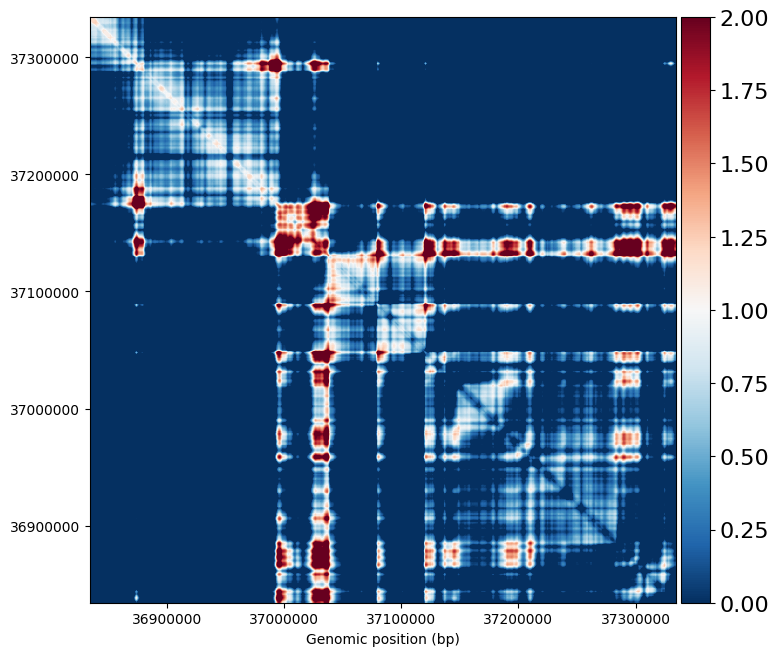

In [21]:
chrom, start, end = ['chr9', 36834268, 37334268] # around PAX5

input_x = prepare_input(
    fasta_extractor,
    chrom, start, end,
    atac_data
).to(device)

_,_,outputs,_ = model(input_x,return_rep=True) #
hic_map=outputs[3][0,:,:,0].cpu().data.detach().numpy() #O/E micro-c
hic_map = np.squeeze(hic_map)
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(hic_map.squeeze(),cmap='RdBu_r',vmin=0,vmax=2,extent=[start, end, start, end],)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.ax.tick_params(labelsize=16)
ax.ticklabel_format(axis='x', style='plain', useOffset=False)
ax.ticklabel_format(axis='y', style='plain', useOffset=False)
ax.set_xlabel("Genomic position (bp)", fontsize=10)
# ax.set_yticks([])
# ax.set_xticks([])
plt.show()

#### HiC

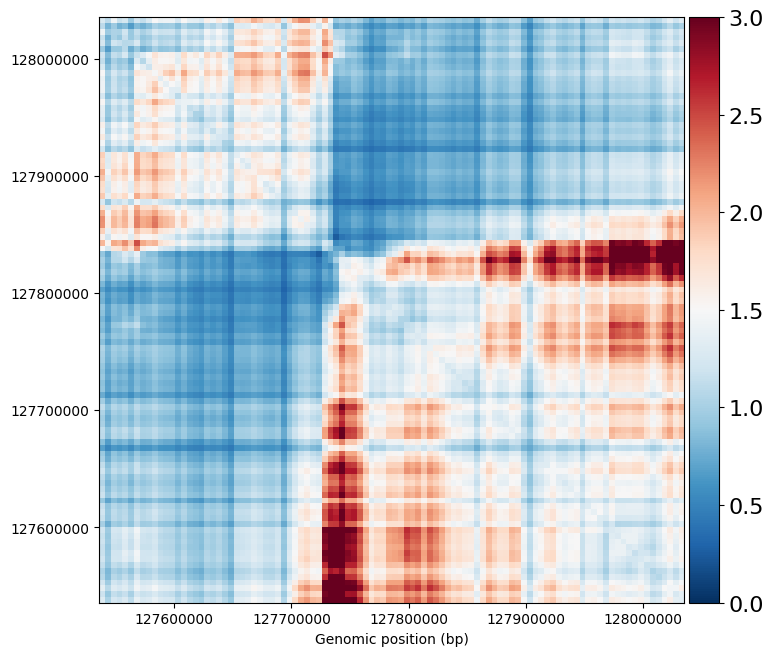

In [24]:
chrom, start, end = ['chr8', 127535434, 128035434] # around MYC

input_x = prepare_input(
    fasta_extractor,
    chrom, start, end,
    atac_data
).to(device)

_,_,outputs,_ = model(input_x,return_rep=True) #
hic_map=outputs[4][0,:,:,2].cpu().data.detach().numpy() #HiC
hic_map = np.squeeze(hic_map)
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(hic_map.squeeze(),cmap='RdBu_r',vmin=0,vmax=3,extent=[start, end, start, end],)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.ax.tick_params(labelsize=16)
ax.ticklabel_format(axis='x', style='plain', useOffset=False)
ax.ticklabel_format(axis='y', style='plain', useOffset=False)
ax.set_xlabel("Genomic position (bp)", fontsize=10)
# ax.set_yticks([])
# ax.set_xticks([])
plt.show()

#### Intact Hi-C

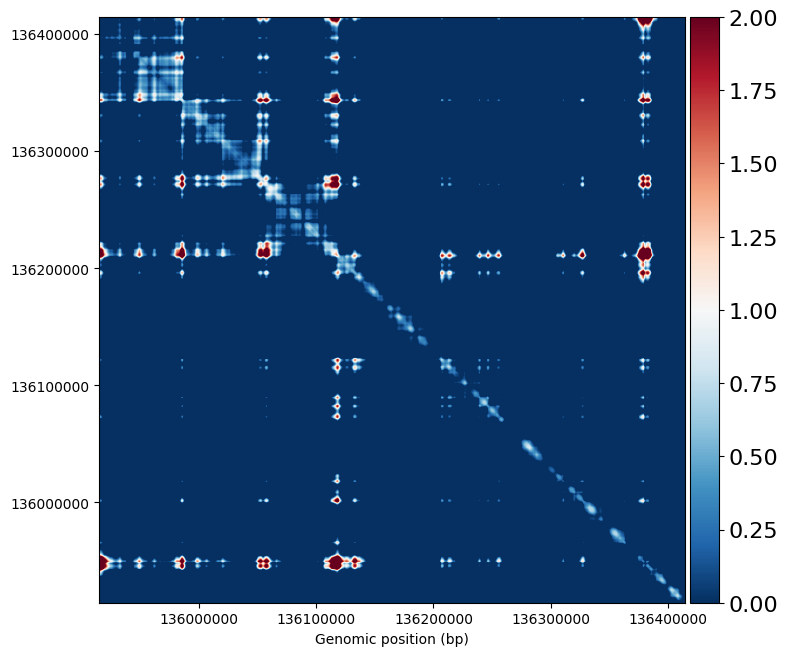

In [27]:
chrom, start, end = ['chr2', 135914349, 136414349] # around CXCR4

input_x = prepare_input(
    fasta_extractor,
    chrom, start, end,
    atac_data
).to(device)

_,_,outputs,_ = model(input_x,return_rep=True) #
hic_map=outputs[5][0,:,:,0].cpu().data.detach().numpy() # O/E normalized intact Hi-C
hic_map = np.squeeze(hic_map)
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(hic_map.squeeze(),cmap='RdBu_r',vmin=0,vmax=2,extent=[start, end, start, end],)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.ax.tick_params(labelsize=16)
ax.ticklabel_format(axis='x', style='plain', useOffset=False)
ax.ticklabel_format(axis='y', style='plain', useOffset=False)
ax.set_xlabel("Genomic position (bp)", fontsize=10)
# ax.set_yticks([])
# ax.set_xticks([])
plt.show()

#### RNA Strand

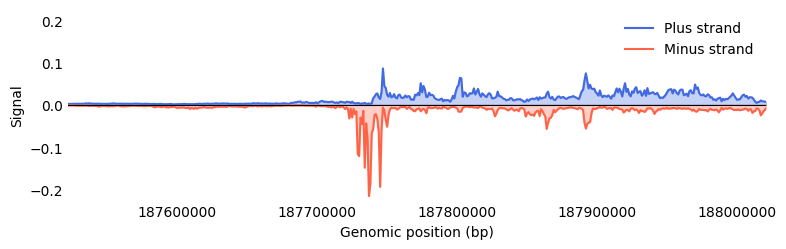

In [ ]:
chrom, start, end = ['chr3', 187521377, 188021377] # around BCL6

input_x = prepare_input(
    fasta_extractor,
    chrom, start, end,
    atac_data
).to(device)

_,_,outputs,_ = model(input_x,return_rep=True) #

epi_map_plus  = outputs[6][0, :, 0].detach().cpu().numpy() # Total RNA-seq (forward)
epi_map_minus = outputs[6][0, :, 1].detach().cpu().numpy() # Total RNA-seq (reverse)

n_bins = epi_map_plus.shape[0]
pixel_width   = (end - start) / n_bins
genomic_coords = start + pixel_width/2 + np.arange(n_bins) * pixel_width

sig_plus  = np.clip(epi_map_plus,  0, None)
sig_minus = -np.clip(epi_map_minus, 0, None) 

fig, ax = plt.subplots(figsize=(8, 2.6))

ax.plot(genomic_coords, sig_plus,  lw=1.5, label='Plus strand', color='royalblue')
ax.fill_between(genomic_coords, 0, sig_plus,  alpha=0.3, color='royalblue')

ax.plot(genomic_coords, sig_minus, lw=1.5, label='Minus strand', color='tomato')
ax.fill_between(genomic_coords, 0, sig_minus, alpha=0.3, color='tomato')

ax.axhline(0, color='k', lw=0.8)
max_sig = max(sig_plus.max() if sig_plus.size else 0,
              (-sig_minus).max() if sig_minus.size else 0)
ax.set_ylim(-max_sig*1.05, max_sig*1.05)

xlim = (genomic_coords.min(), genomic_coords.max())
ax.set_xlim(xlim)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(axis='both', which='both', length=0)
ax.ticklabel_format(axis='x', style='plain', useOffset=False)
ax.set_xlabel("Genomic position (bp)", fontsize=10)
ax.set_ylabel("Signal", fontsize=10)
ax.legend(frameon=False, loc='upper right')
plt.tight_layout()
plt.show()

#### Additional TFs

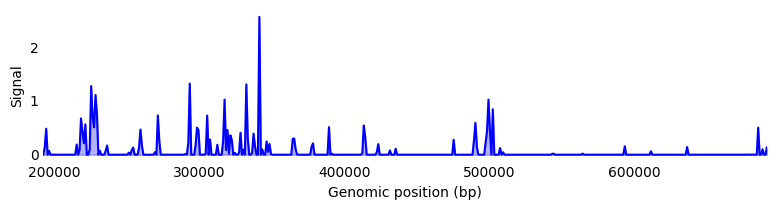

In [29]:
chrom, start, end = ['chr6', 191752, 691752] #aroud gene IRF4

input_x = prepare_input(
    fasta_extractor,
    chrom, start, end,
    atac_data
).to(device)

_,_,_,outputs = model(input_x,return_rep=True)

epi_map=outputs[0][0,:,37].cpu().data.detach().numpy() #CBX2
n_bins = epi_map.shape[0]
pixel_width   = (end - start) / n_bins
genomic_coords = start + pixel_width/2 + np.arange(n_bins) * pixel_width
fig, ax = plt.subplots(figsize=(8, 2.2))
sig = np.clip(epi_map, 0, None)
ax.plot(genomic_coords, sig, color='blue', lw=1.5)
ax.fill_between(genomic_coords, 0, sig, alpha=0.3, color='blue')

xlim = (genomic_coords.min(), genomic_coords.max())
ax.set_xlim(xlim)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(axis='both', which='both', length=0)
ax.ticklabel_format(axis='x', style='plain', useOffset=False)
ax.set_xlabel("Genomic position (bp)", fontsize=10)
ax.set_ylabel("Signal", fontsize=10)
plt.tight_layout()

plt.show()

#### TT-seq

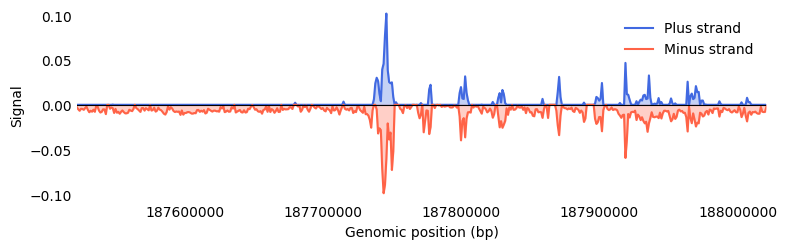

In [30]:
chrom, start, end = ['chr3', 187521377, 188021377] # around BCL6

input_x = prepare_input(
    fasta_extractor,
    chrom, start, end,
    atac_data
).to(device)

_,_,_,outputs = model(input_x,return_rep=True) #

epi_map_plus  = outputs[1][0, :, 0].detach().cpu().numpy() # TT-seq (forward)
epi_map_minus = outputs[1][0, :, 1].detach().cpu().numpy() # TT-seq (reverse)

n_bins = epi_map_plus.shape[0]
pixel_width   = (end - start) / n_bins
genomic_coords = start + pixel_width/2 + np.arange(n_bins) * pixel_width

sig_plus  = np.clip(epi_map_plus,  0, None)
sig_minus = -np.clip(epi_map_minus, 0, None) 

fig, ax = plt.subplots(figsize=(8, 2.6))

ax.plot(genomic_coords, sig_plus,  lw=1.5, label='Plus strand', color='royalblue')
ax.fill_between(genomic_coords, 0, sig_plus,  alpha=0.3, color='royalblue')

ax.plot(genomic_coords, sig_minus, lw=1.5, label='Minus strand', color='tomato')
ax.fill_between(genomic_coords, 0, sig_minus, alpha=0.3, color='tomato')

ax.axhline(0, color='k', lw=0.8)
max_sig = max(sig_plus.max() if sig_plus.size else 0,
              (-sig_minus).max() if sig_minus.size else 0)
ax.set_ylim(-max_sig*1.05, max_sig*1.05)

xlim = (genomic_coords.min(), genomic_coords.max())
ax.set_xlim(xlim)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(axis='both', which='both', length=0)
ax.ticklabel_format(axis='x', style='plain', useOffset=False)
ax.set_xlabel("Genomic position (bp)", fontsize=10)
ax.set_ylabel("Signal", fontsize=10)
ax.legend(frameon=False, loc='upper right')
plt.tight_layout()
plt.show()

#### GRO-seq

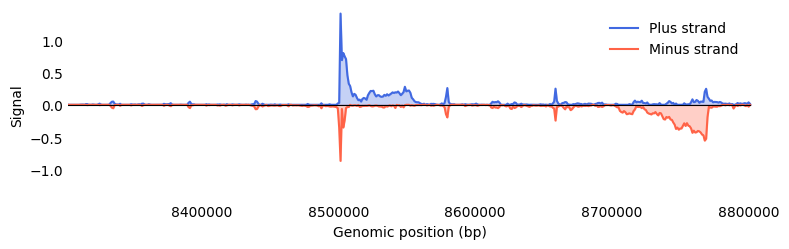

In [31]:
chrom, start, end = ['chr3', 8302155, 8802155] # around AID

input_x = prepare_input(
    fasta_extractor,
    chrom, start, end,
    atac_data
).to(device)

_,_,_,outputs = model(input_x,return_rep=True) #

epi_map_plus  = outputs[2][0, :, 0].detach().cpu().numpy() # GRO-seq (forward)
epi_map_minus = outputs[2][0, :, 1].detach().cpu().numpy() # GRO-seq (reverse)

n_bins = epi_map_plus.shape[0]
pixel_width   = (end - start) / n_bins
genomic_coords = start + pixel_width/2 + np.arange(n_bins) * pixel_width

sig_plus  = np.clip(epi_map_plus,  0, None)
sig_minus = -np.clip(epi_map_minus, 0, None) 

fig, ax = plt.subplots(figsize=(8, 2.6))

ax.plot(genomic_coords, sig_plus,  lw=1.5, label='Plus strand', color='royalblue')
ax.fill_between(genomic_coords, 0, sig_plus,  alpha=0.3, color='royalblue')

ax.plot(genomic_coords, sig_minus, lw=1.5, label='Minus strand', color='tomato')
ax.fill_between(genomic_coords, 0, sig_minus, alpha=0.3, color='tomato')

ax.axhline(0, color='k', lw=0.8)
max_sig = max(sig_plus.max() if sig_plus.size else 0,
              (-sig_minus).max() if sig_minus.size else 0)
ax.set_ylim(-max_sig*1.05, max_sig*1.05)

xlim = (genomic_coords.min(), genomic_coords.max())
ax.set_xlim(xlim)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(axis='both', which='both', length=0)
ax.ticklabel_format(axis='x', style='plain', useOffset=False)
ax.set_xlabel("Genomic position (bp)", fontsize=10)
ax.set_ylabel("Signal", fontsize=10)
ax.legend(frameon=False, loc='upper right')
plt.tight_layout()
plt.show()

#### GRO-cap

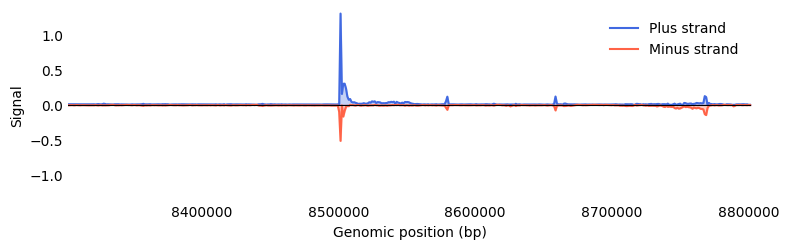

In [32]:
chrom, start, end = ['chr3', 8302155, 8802155] # around AID

input_x = prepare_input(
    fasta_extractor,
    chrom, start, end,
    atac_data
).to(device)

_,_,_,outputs = model(input_x,return_rep=True) #

epi_map_plus  = outputs[3][0, :, 0].detach().cpu().numpy() # GRO-cap (forward)
epi_map_minus = outputs[3][0, :, 1].detach().cpu().numpy() # GRO-cap (reverse)

n_bins = epi_map_plus.shape[0]
pixel_width   = (end - start) / n_bins
genomic_coords = start + pixel_width/2 + np.arange(n_bins) * pixel_width

sig_plus  = np.clip(epi_map_plus,  0, None)
sig_minus = -np.clip(epi_map_minus, 0, None) 

fig, ax = plt.subplots(figsize=(8, 2.6))

ax.plot(genomic_coords, sig_plus,  lw=1.5, label='Plus strand', color='royalblue')
ax.fill_between(genomic_coords, 0, sig_plus,  alpha=0.3, color='royalblue')

ax.plot(genomic_coords, sig_minus, lw=1.5, label='Minus strand', color='tomato')
ax.fill_between(genomic_coords, 0, sig_minus, alpha=0.3, color='tomato')

ax.axhline(0, color='k', lw=0.8)
max_sig = max(sig_plus.max() if sig_plus.size else 0,
              (-sig_minus).max() if sig_minus.size else 0)
ax.set_ylim(-max_sig*1.05, max_sig*1.05)

xlim = (genomic_coords.min(), genomic_coords.max())
ax.set_xlim(xlim)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(axis='both', which='both', length=0)
ax.ticklabel_format(axis='x', style='plain', useOffset=False)
ax.set_xlabel("Genomic position (bp)", fontsize=10)
ax.set_ylabel("Signal", fontsize=10)
ax.legend(frameon=False, loc='upper right')
plt.tight_layout()
plt.show()

#### Pro-seq

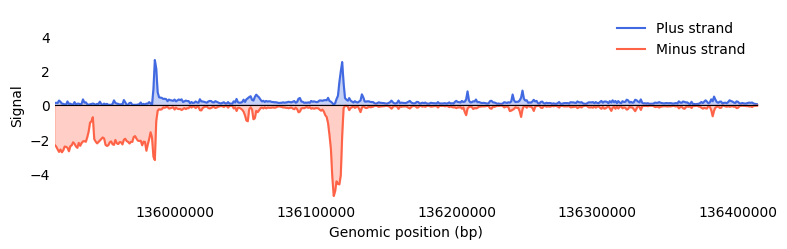

In [33]:
chrom, start, end = ['chr2', 135914349, 136414349] # around CXCR4

input_x = prepare_input(
    fasta_extractor,
    chrom, start, end,
    atac_data
).to(device)

_,_,_,outputs = model(input_x,return_rep=True) #

epi_map_plus  = outputs[4][0, :, 0].detach().cpu().numpy() # PRO-cap (forward)
epi_map_minus = outputs[4][0, :, 1].detach().cpu().numpy() # PRO-cap (reverse)

n_bins = epi_map_plus.shape[0]
pixel_width   = (end - start) / n_bins
genomic_coords = start + pixel_width/2 + np.arange(n_bins) * pixel_width

sig_plus  = np.clip(epi_map_plus,  0, None)
sig_minus = -np.clip(epi_map_minus, 0, None) 

fig, ax = plt.subplots(figsize=(8, 2.6))

ax.plot(genomic_coords, sig_plus,  lw=1.5, label='Plus strand', color='royalblue')
ax.fill_between(genomic_coords, 0, sig_plus,  alpha=0.3, color='royalblue')

ax.plot(genomic_coords, sig_minus, lw=1.5, label='Minus strand', color='tomato')
ax.fill_between(genomic_coords, 0, sig_minus, alpha=0.3, color='tomato')

ax.axhline(0, color='k', lw=0.8)
max_sig = max(sig_plus.max() if sig_plus.size else 0,
              (-sig_minus).max() if sig_minus.size else 0)
ax.set_ylim(-max_sig*1.05, max_sig*1.05)

xlim = (genomic_coords.min(), genomic_coords.max())
ax.set_xlim(xlim)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(axis='both', which='both', length=0)
ax.ticklabel_format(axis='x', style='plain', useOffset=False)
ax.set_xlabel("Genomic position (bp)", fontsize=10)
ax.set_ylabel("Signal", fontsize=10)
ax.legend(frameon=False, loc='upper right')
plt.tight_layout()
plt.show()

#### NET-CAGE

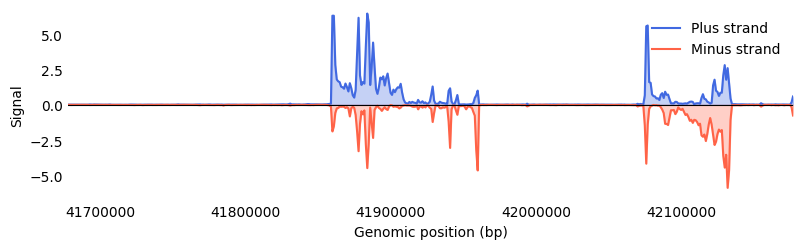

In [34]:
chrom, start, end = ['chr19', 41677279, 42177279] # around CD79A

input_x = prepare_input(
    fasta_extractor,
    chrom, start, end,
    atac_data
).to(device)

_,_,_,outputs = model(input_x,return_rep=True) #

epi_map_plus  = outputs[5][0, :, 0].detach().cpu().numpy() # NET-CAGE (forward)
epi_map_minus = outputs[5][0, :, 1].detach().cpu().numpy() # NET-CAGE (reverse)

n_bins = epi_map_plus.shape[0]
pixel_width   = (end - start) / n_bins
genomic_coords = start + pixel_width/2 + np.arange(n_bins) * pixel_width

sig_plus  = np.clip(epi_map_plus,  0, None)
sig_minus = -np.clip(epi_map_minus, 0, None) 

fig, ax = plt.subplots(figsize=(8, 2.6))

ax.plot(genomic_coords, sig_plus,  lw=1.5, label='Plus strand', color='royalblue')
ax.fill_between(genomic_coords, 0, sig_plus,  alpha=0.3, color='royalblue')

ax.plot(genomic_coords, sig_minus, lw=1.5, label='Minus strand', color='tomato')
ax.fill_between(genomic_coords, 0, sig_minus, alpha=0.3, color='tomato')

ax.axhline(0, color='k', lw=0.8)
max_sig = max(sig_plus.max() if sig_plus.size else 0,
              (-sig_minus).max() if sig_minus.size else 0)
ax.set_ylim(-max_sig*1.05, max_sig*1.05)

xlim = (genomic_coords.min(), genomic_coords.max())
ax.set_xlim(xlim)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(axis='both', which='both', length=0)
ax.ticklabel_format(axis='x', style='plain', useOffset=False)
ax.set_xlabel("Genomic position (bp)", fontsize=10)
ax.set_ylabel("Signal", fontsize=10)
ax.legend(frameon=False, loc='upper right')
plt.tight_layout()
plt.show()

#### STARR-seq

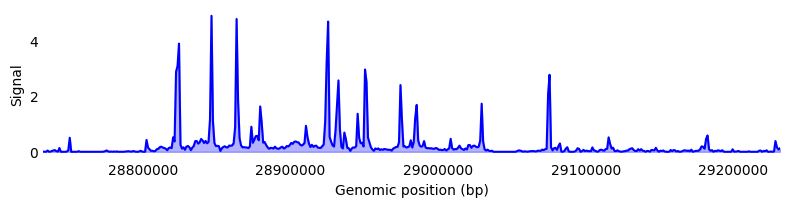

In [35]:
chrom, start, end = ['chr16', 28731965, 29231965] #aroud gene CD19

input_x = prepare_input(
    fasta_extractor,
    chrom, start, end,
    atac_data
).to(device)

_,_,_,outputs = model(input_x,return_rep=True)

epi_map=outputs[6][0,:,0].cpu().data.detach().numpy() 
n_bins = epi_map.shape[0]
pixel_width   = (end - start) / n_bins
genomic_coords = start + pixel_width/2 + np.arange(n_bins) * pixel_width
fig, ax = plt.subplots(figsize=(8, 2.2))
sig = np.clip(epi_map, 0, None)
ax.plot(genomic_coords, sig, color='blue', lw=1.5)
ax.fill_between(genomic_coords, 0, sig, alpha=0.3, color='blue')

xlim = (genomic_coords.min(), genomic_coords.max())
ax.set_xlim(xlim)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(axis='both', which='both', length=0)
ax.ticklabel_format(axis='x', style='plain', useOffset=False)
ax.set_xlabel("Genomic position (bp)", fontsize=10)
ax.set_ylabel("Signal", fontsize=10)
plt.tight_layout()

plt.show()